Content:

1.Visualisations using SQL queries

2.Data Cleaning

3.Challenges Faced

4.Linear Regression

5.Linear SVC

6.Comparison of Logistic and Linear SVC based on their accuracies

7.Logistic Regression

https://www.kaggle.com/ericpierce/austinhousingprices

This is a dataset for Austin, TX House Listings

They are features and Images scraped in January 2021

These home listings were scraped from Zillow.com using their official API, via apify.com. This data was scraped on January 31st, 2021.

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('FProj').getOrCreate()

In [0]:
original_df = spark.read.csv('/FileStore/tables/austinfinalcleandata2.csv',inferSchema=True,header=True)
original_df.head(1)

Out[7]: [Row(zpid=111373431, city='pflugerville', streetAddress='14424 Lake Victor Dr', zipcode=78660, latitude=30.43063164, longitude=-97.66307831, propertyTaxRate=1.98, garageSpaces=2, hasAssociation=0, hasCooling=0, hasGarage=0, hasHeating=0, hasSpa=1, hasView=1, homeType='Single Family', parkingSpaces=2, yearBuilt=2012, latestPrice=305000, numPriceChanges=5, latest_salemonth=9, latest_saleyear=2019, latestPriceSource='Coldwell Banker United Realtors - South Austin', numOfPhotos=39, numOfAccessibilityFeatures=0, numOfAppliances=5, numOfParkingFeatures=2, numOfPatioAndPorchFeatures=1, numOfSecurityFeatures=3, numOfWaterfrontFeatures=0, numOfWindowFeatures=1, numOfCommunityFeatures=0, lotSizeSqFt=6011.0, livingAreaSqFt=2601, numOfPrimarySchools=1, numOfElementarySchools=0, numOfMiddleSchools=1, numOfHighSchools=1, avgSchoolDistance=1.266666667, avgSchoolRating=2.666666667, avgSchoolSize=1063, MedianStudentsPerTeacher=14, numOfBathrooms=3.0, numOfBedrooms=4, numOfStories=2)]

In [0]:
# Create a view or table
original_df.createOrReplaceTempView('austinhousingdata_csv')

In [0]:
%sql
select count(*) as Total_Houses,city from austinhousingdata_csv group by city order by Total_Houses desc 

Total_Houses,city
15020,austin
86,del valle
36,pflugerville
12,driftwood
6,manor
5,dripping springs
3,manchaca
2,west lake hills
1,road


INTERESTING OBSERVATION:

We can see in the below two charts that a lot of houses were built from 2004 to 2007 before the major realestate crash and great recession in 2009

In [0]:
%sql
select count(*) as Total_Houses,yearbuilt as Years
from austinhousingdata_csv 
group by Years 
HAVING COUNT(*)>200
order by Total_Houses desc limit 20;


Total_Houses,Years
495,2006
399,1999
398,2005
391,2007
358,1983
353,1984
323,2004
316,2015
315,1982
314,2014


In [0]:
%sql
select count(*) as Total_Houses,yearbuilt as Years
from austinhousingdata_csv 
group by Years
order by Years;

Total_Houses,Years
34,null
1,1905
1,1906
3,1907
1,1908
2,1909
7,1910
1,1911
4,1912
3,1914


In [0]:
%sql
select count(*) as Total_houses,propertytaxrate as Property_tax_rate from austinhousingdata_csv group by Property_tax_rate order by Total_houses desc 

Total_houses,Property_tax_rate
13755,1.98
856,2.21
560,2.01


In [0]:
%sql
select count(*) as Total_houses,garagespaces as parking_spaces from austinhousingdata_csv group by parking_spaces order by Total_houses desc 

Total_houses,parking_spaces
6819,0
5493,2
1097,1
932,3
579,4
99,6
72,5
34,null
17,8
11,7


In [0]:
%sql
select count(*) as total_houses,hometype as type_of_houses from austinhousingdata_csv group by type_of_houses order by total_houses desc 

total_houses,type_of_houses
14241,Single Family
470,Condo
174,Townhouse
96,Multiple Occupancy
83,Vacant Land
37,Residential
37,Apartment
17,Mobile / Manufactured
10,MultiFamily
6,Other


In [0]:
from pyspark.sql import functions as F

latest_price_df = original_df.withColumn(
    'pricegroup',F.when(F.col("latestprice").between(100000, 250000), "100-250K")\
    .when(F.col("latestprice").between(250000, 400000), "250-400K")\
    .when(F.col("latestprice").between(400000, 600000), "400-600K")\
    .when(F.col("latestprice").between(600000, 800000), "600-800K")\
    .when(F.col("latestprice").between(800000, 1000000), "800K- 1 million")\
    .when(F.col("latestprice").between(1000000, 9999999999999), "Above 1 million")\
    .when(F.col("latestprice").between(0, 100000), "Less than 100K")\
)
latest_price_df.createOrReplaceTempView('latest_price_table')

In [0]:
%sql 
select pricegroup as price_range, count(*) as total_houses from latest_price_table group by pricegroup order by total_houses desc limit 5

price_range,total_houses
250-400K,5575
400-600K,4347
100-250K,1934
600-800K,1638
Above 1 million,929


Till now we worked on understanding the original dataset. For the next part of this project, we'll be building different models to see how they predict the dependent variables we'll be taking. To get good results out of the models, we had to remove 34 rows that were outliers which were causing the model accuracies to drop. Once we removed those our model accuracies increased drastically from 40% to nearly 78%. Apart from these 34 rows, we also removed some columns that had extremely low correlation values (as shown in the ppt/video recording) as these were not useful for the analysis.

For both the original dataset and the dataset used for models, we removed the column "description" as it was uneccesary for these models but can be used to perform analysis using NLP models in future.

All the rows and columns removal happened before they were uploaded to the databricks platform. We used Excel to remove them.

In [0]:
df = spark.read.csv('/FileStore/tables/austinHousingData_LivingArea-1.csv',inferSchema=True,header=True)
df.head(1)

Out[10]: [Row(garageSpaces=2, hasAssociation=0, hasCooling=0, hasGarage=0, hasHeating=0, hasSpa=1, hasView=1, parkingSpaces=2, yearBuilt=2012, latestPrice=305000, numPriceChanges=5, latest_salemonth=9, latest_saleyear=2019, numOfPhotos=39, numOfAccessibilityFeatures=0, numOfAppliances=5, numOfParkingFeatures=2, numOfPatioAndPorchFeatures=1, numOfSecurityFeatures=3, numOfWaterfrontFeatures=0, numOfWindowFeatures=1, numOfCommunityFeatures=0, lotSizeSqFt=6011.0, livingAreaSqFt=2601, numOfPrimarySchools=1, numOfElementarySchools=0, numOfMiddleSchools=1, numOfHighSchools=1, avgSchoolDistance=1.266666667, avgSchoolRating=2.666666667, avgSchoolSize=1063, MedianStudentsPerTeacher=14, numOfBathrooms=3.0, numOfBedrooms=4, numOfStories=2)]

In [0]:
df.createOrReplaceTempView("austinHousing")

In [0]:
%sql
select * from austinHousing

garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
2,0,0,0,0,1,1,2,2012,305000,5,9,2019,39,0,5,2,1,3,0,1,0,6011.0,2601,1,0,1,1,1.266666667,2.666666667,1063,14,3.0,4,2
2,0,0,0,0,1,1,2,2013,295000,1,10,2020,29,0,1,2,0,0,0,0,0,6185.0,1768,1,0,1,1,1.4,2.666666667,1063,14,2.0,4,1
0,0,0,1,0,1,1,0,2018,256125,1,7,2019,2,0,4,1,0,1,0,0,0,7840.0,1478,0,2,1,1,1.2,3.0,1108,14,2.0,3,1
2,0,0,0,0,1,1,2,2013,240000,4,8,2018,9,0,0,2,0,0,0,0,0,6098.0,1678,1,0,1,1,1.4,2.666666667,1063,14,2.0,3,1
0,0,0,1,0,1,1,0,2002,239900,3,10,2018,27,0,0,1,0,0,0,0,0,6708.0,2132,1,0,1,1,1.133333333,4.0,1223,14,3.0,3,2
2,0,0,0,0,1,1,2,2020,309045,2,8,2020,2,0,3,1,2,2,0,0,0,5161.0,1446,1,0,1,1,1.066666667,4.0,1223,14,2.0,3,1
0,0,1,1,1,1,1,0,2016,315000,2,6,2020,36,0,3,1,0,0,0,0,0,12196.8,2432,1,0,1,1,1.233333333,3.666666667,1051,12,3.0,4,2
0,0,0,1,0,1,1,0,2002,219900,2,10,2018,21,0,3,1,0,0,0,0,0,5140.0,1422,1,0,1,1,1.166666667,4.0,1223,14,3.0,3,2
0,0,0,1,0,1,1,0,2002,225000,1,9,2019,16,0,2,1,1,1,0,0,0,3811.0,1870,1,0,1,1,1.166666667,4.0,1223,14,2.0,3,2
2,0,0,0,0,1,1,2,2013,194800,1,9,2018,23,0,3,2,0,0,0,0,0,5183.0,1422,1,0,1,1,1.2,3.0,1615,14,3.0,3,2


The first model that we'll be trying on our texas housing dataset is Linear Regression. After a lot of experimentation and trials, we finalised that the model works best when we select "livingAreaSqft" as the dependent variable. We did try running the model and predict "LatestPrice", taking other independent variables into consideration, but we couldn't come up with a model having r-quare value more than 0.41.

In [0]:
# Import the required libraries
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.clustering import KMeans

from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import pylab as pl

#select only the needed attributes from the original dataset
linear_reg_data = df.select(['garageSpaces','hasAssociation','hasCooling','hasGarage','hasSpa','hasView','parkingSpaces','yearBuilt','latestPrice','numPriceChanges',
'latest_salemonth','latest_saleyear','numOfPhotos','numOfParkingFeatures','numOfAppliances','numOfWindowFeatures','avgSchoolDistance','avgSchoolRating',
'MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms','numOfStories','livingAreaSqFt'])

In [0]:
#change columns of type double to int
linear_reg_data = linear_reg_data.withColumn("numOfBathrooms",linear_reg_data.numOfBathrooms.cast('int'))
linear_reg_data = linear_reg_data.withColumn("avgSchoolRating",linear_reg_data.avgSchoolRating.cast('int'))
linear_reg_data = linear_reg_data.withColumn("avgSchoolDistance",linear_reg_data.avgSchoolDistance.cast('int'))

In [0]:
# Create a 70-30 train test split
train_lineardata,test_lineardata = linear_reg_data.randomSplit([0.7,0.3])

In [0]:
#Schema of the data
linear_reg_data.printSchema()

root
 |-- garageSpaces: integer (nullable = true)
 |-- hasAssociation: integer (nullable = true)
 |-- hasCooling: integer (nullable = true)
 |-- hasGarage: integer (nullable = true)
 |-- hasSpa: integer (nullable = true)
 |-- hasView: integer (nullable = true)
 |-- parkingSpaces: integer (nullable = true)
 |-- yearBuilt: integer (nullable = true)
 |-- latestPrice: integer (nullable = true)
 |-- numPriceChanges: integer (nullable = true)
 |-- latest_salemonth: integer (nullable = true)
 |-- latest_saleyear: integer (nullable = true)
 |-- numOfPhotos: integer (nullable = true)
 |-- numOfParkingFeatures: integer (nullable = true)
 |-- numOfAppliances: integer (nullable = true)
 |-- numOfWindowFeatures: integer (nullable = true)
 |-- avgSchoolDistance: integer (nullable = true)
 |-- avgSchoolRating: integer (nullable = true)
 |-- MedianStudentsPerTeacher: integer (nullable = true)
 |-- numOfBathrooms: integer (nullable = true)
 |-- numOfBedrooms: integer (nullable = true)
 |-- numOfStories

In [0]:
# see how train dataset looks
display(train_lineardata)

garageSpaces,hasAssociation,hasCooling,hasGarage,hasSpa,hasView,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfParkingFeatures,numOfAppliances,numOfWindowFeatures,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,livingAreaSqFt
0,0,0,1,0,0,0,1981,495000,2,2,2018,19,1,5,0,2,7,17,3,3,1,2101
0,0,0,1,0,0,0,1984,798000,3,4,2018,54,1,2,0,4,7,16,2,4,2,2832
0,0,0,1,0,0,0,1984,1175000,10,5,2020,37,3,5,1,5,5,16,3,4,1,3500
0,0,0,1,0,0,0,1985,369000,2,3,2020,40,1,3,0,0,2,14,3,3,2,1552
0,0,0,1,0,0,0,1985,550000,3,11,2018,40,1,5,0,1,8,16,3,3,1,2500
0,0,0,1,0,0,0,1987,450000,4,5,2018,78,1,4,0,3,7,16,3,3,2,2667
0,0,0,1,0,0,0,1990,949500,5,8,2018,35,1,3,0,1,9,14,4,4,2,3119
0,0,0,1,0,0,0,1991,649000,1,7,2019,32,1,3,0,1,7,16,3,5,2,3404
0,0,0,1,0,0,0,1997,1375000,1,3,2020,36,2,4,0,2,9,15,5,4,2,3711
0,0,0,1,0,0,0,1998,1149000,2,8,2018,37,1,2,0,6,6,16,5,4,1,4641


In [0]:
# Vector assembler is used to create a vector of input features. It basically transforms the input columns into a single vector.
linear_assembler = VectorAssembler(inputCols=['garageSpaces','hasAssociation','hasCooling','hasGarage','hasSpa','hasView','parkingSpaces',
                                       'yearBuilt','latestPrice','numPriceChanges',
                                       'latest_salemonth','latest_saleyear','numOfPhotos','numOfParkingFeatures',
                                       'numOfAppliances','numOfWindowFeatures','avgSchoolDistance','avgSchoolRating',
                                       'MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms','numOfStories'],
                            outputCol="features")

In [0]:
# Create an object for the linear regression model
lr_model = LinearRegression(labelCol='livingAreaSqFt')

In [0]:
# A pipeline consists of a sequence of stages
pipe_linear = Pipeline(stages=[linear_assembler, lr_model])
fit_model=pipe_linear.fit(train_lineardata)
results_linear = fit_model.transform(test_lineardata)
results_linear.select(['livingAreaSqFt','prediction']).show(10)

+--------------+------------------+
|livingAreaSqFt|        prediction|
+--------------+------------------+
|          2659| 2128.387561055395|
|          3070|3291.7385892156744|
|          6468| 5366.673457257537|
|          3400| 4141.609721590357|
|          3096| 3582.893017035676|
|          4407|4065.4926600889885|
|          5411| 4131.966769363731|
|          3427|   3558.0476090101|
|          4116|3919.3096359253686|
|          6530| 6287.179889930907|
+--------------+------------------+
only showing top 10 rows



In [0]:
#Both RMSE and R2 quantify how well a regression model fits a dataset.
#The RMSE tells us how well a regression model can predict the value of the response variable in absolute terms.
#R2 tells us how well a model can predict the value of the response variable in percentage terms.

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="livingAreaSqFt",metricName="r2")
r2=lr_evaluator.evaluate(results_linear)
print("R squared value is {}".format(r2))
 
#root mean squared error term
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="livingAreaSqFt",metricName="rmse")
rmse=rmse_evaluator.evaluate(results_linear)
print("Root mean squared error value is {}".format(rmse))
 
#mean sqared error
mse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="livingAreaSqFt",metricName="mse")
mse=mse_evaluator.evaluate(results_linear)
print("Mean squared error value is {}".format(mse))

R squared value is 0.7799044074999587
Root mean squared error value is 493.5196319033562
Mean squared error value is 243561.6270740242


Below code shows that the linear regression model has r-squared value : 0.78

This means that 78% of the variance in the dependent variable is being caused by the independent variables

The next two models are going to be LinearSVC and Logistic Regression. In these models we'll be using "hasAssociation" as the dependent variable because these models can only predict a categorical variable with 2 levels. Another reason for selecting "hasAssociation" particularly is because it's the only best variable with high correlations and with both the categories evenly spread accross the whole data. Below SQL output shows the total number of one's (around 7147 rows) and zero's (around 7990 rows).

We also used a dummy coding strategy where True was coded as 0 and False was coded as 1

In [0]:
%sql
select hasAssociation, count(*) as Count from austinHousing group by hasAssociation;

hasAssociation,Count
1,7147
0,7990


In [0]:
#select only the needed attributes from the original dataset
svc_data = df.select(['garageSpaces','hasCooling','hasGarage','parkingSpaces',
                           'yearBuilt','latestPrice','numPriceChanges',
                           'latest_salemonth','latest_saleyear','numOfAccessibilityFeatures','numOfParkingFeatures',
                           'numOfSecurityFeatures','numOfWindowFeatures','avgSchoolDistance',
                           'MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms','numOfCommunityFeatures','livingAreaSqFt',
                           'numOfPrimarySchools','numOfElementarySchools','numOfMiddleSchools','numOfHighSchools',
                           'avgSchoolSize','hasAssociation'])

In [0]:
# check the schema (the attributed and their data types) in the dataset
svc_data.printSchema()

root
 |-- garageSpaces: integer (nullable = true)
 |-- hasCooling: integer (nullable = true)
 |-- hasGarage: integer (nullable = true)
 |-- parkingSpaces: integer (nullable = true)
 |-- yearBuilt: integer (nullable = true)
 |-- latestPrice: integer (nullable = true)
 |-- numPriceChanges: integer (nullable = true)
 |-- latest_salemonth: integer (nullable = true)
 |-- latest_saleyear: integer (nullable = true)
 |-- numOfAccessibilityFeatures: integer (nullable = true)
 |-- numOfParkingFeatures: integer (nullable = true)
 |-- numOfSecurityFeatures: integer (nullable = true)
 |-- numOfWindowFeatures: integer (nullable = true)
 |-- avgSchoolDistance: double (nullable = true)
 |-- MedianStudentsPerTeacher: integer (nullable = true)
 |-- numOfBathrooms: double (nullable = true)
 |-- numOfBedrooms: integer (nullable = true)
 |-- numOfCommunityFeatures: integer (nullable = true)
 |-- livingAreaSqFt: integer (nullable = true)
 |-- numOfPrimarySchools: integer (nullable = true)
 |-- numOfElementa

In [0]:
# converting the attributes of type double to int
svc_data = svc_data.withColumn("numOfBathrooms",svc_data.numOfBathrooms.cast('int'))
svc_data = svc_data.withColumn("avgSchoolDistance",svc_data.avgSchoolDistance.cast('int'))

In [0]:
# splitting data randomly into train and test 
train_SVCdata,test_SVCdata = svc_data.randomSplit([0.7,0.3])
print("Training data size: ", train_SVCdata.count())
print("Testing data size: ", test_SVCdata.count())

Training data size:  10569
Testing data size:  4568


In [0]:
# Vector assembler is used to create a vector of input features. It basically transforms the input columns into a single vector.
scv_assembler = VectorAssembler(inputCols=['garageSpaces','hasCooling','hasGarage','parkingSpaces',
                           'yearBuilt','latestPrice','numPriceChanges',
                           'latest_salemonth','latest_saleyear','numOfAccessibilityFeatures','numOfParkingFeatures',
                           'numOfSecurityFeatures','numOfWindowFeatures','avgSchoolDistance',
                           'MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms','numOfCommunityFeatures','livingAreaSqFt',
                           'numOfPrimarySchools','numOfElementarySchools','numOfMiddleSchools','numOfHighSchools',
                           'avgSchoolSize'],outputCol="unscaled_features")

In [0]:
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

In [0]:
# Create an object for the linear SVC model
svc_model = LinearSVC(labelCol='hasAssociation')

In [0]:
# A pipeline consists of a sequence of stages
pipe_svc = Pipeline(stages=[scv_assembler, scaler, svc_model])
fit_model_svc=pipe_svc.fit(train_SVCdata)
results_svc = fit_model_svc.transform(test_SVCdata)
results_svc.select(['hasAssociation','prediction']).show(10)

+--------------+----------+
|hasAssociation|prediction|
+--------------+----------+
|             1|       1.0|
|             1|       0.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             0|       1.0|
+--------------+----------+
only showing top 10 rows



In [0]:
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='hasAssociation',metricName='areaUnderROC')
#Computing the Area Under the Curve
AUC = AUC_evaluator.evaluate(results_svc)
print("The area under the curve is {}".format(AUC))
 
#Computing the accuracy 
ACC_evaluator = MulticlassClassificationEvaluator(labelCol="hasAssociation", predictionCol="prediction", metricName="accuracy")
accuracy = ACC_evaluator.evaluate(results_svc)
print("The accuracy of the model is {}".format(accuracy))

The area under the curve is 0.7851266804306564
The accuracy of the model is 0.7874343257443083


Accuracy of the linear SVC: 78.7%.

This means that 78% of the variance in the dependent variable is being predicted by the independent variables

In [0]:
y_true = results_svc.select("hasAssociation")
y_true = y_true.toPandas()
 
y_pred = results_svc.select("prediction")
y_pred = y_pred.toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix for linear SVC regression model is: \n {}".format(cnf_matrix))
 

Below is the confusion matrix for linear SVC regression model is: 
 [[1993  418]
 [ 553 1604]]


In [0]:
#select only the needed attributes from the original dataset
logistic_data = df.select(['garageSpaces','hasCooling','hasGarage','parkingSpaces',
                           'yearBuilt','latestPrice','numPriceChanges',
                           'latest_salemonth','latest_saleyear','numOfAccessibilityFeatures','numOfParkingFeatures',
                           'numOfSecurityFeatures','numOfWindowFeatures','avgSchoolDistance',
                           'MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms','numOfCommunityFeatures','livingAreaSqFt',
                           'numOfPrimarySchools','numOfElementarySchools','numOfMiddleSchools','numOfHighSchools',
                           'avgSchoolSize','hasAssociation'])

In [0]:
logistic_data.printSchema()

root
 |-- garageSpaces: integer (nullable = true)
 |-- hasCooling: integer (nullable = true)
 |-- hasGarage: integer (nullable = true)
 |-- parkingSpaces: integer (nullable = true)
 |-- yearBuilt: integer (nullable = true)
 |-- latestPrice: integer (nullable = true)
 |-- numPriceChanges: integer (nullable = true)
 |-- latest_salemonth: integer (nullable = true)
 |-- latest_saleyear: integer (nullable = true)
 |-- numOfAccessibilityFeatures: integer (nullable = true)
 |-- numOfParkingFeatures: integer (nullable = true)
 |-- numOfSecurityFeatures: integer (nullable = true)
 |-- numOfWindowFeatures: integer (nullable = true)
 |-- avgSchoolDistance: double (nullable = true)
 |-- MedianStudentsPerTeacher: integer (nullable = true)
 |-- numOfBathrooms: double (nullable = true)
 |-- numOfBedrooms: integer (nullable = true)
 |-- numOfCommunityFeatures: integer (nullable = true)
 |-- livingAreaSqFt: integer (nullable = true)
 |-- numOfPrimarySchools: integer (nullable = true)
 |-- numOfElementa

In [0]:
# converting the attributes of type double to int
logistic_data = logistic_data.withColumn("numOfBathrooms",logistic_data.numOfBathrooms.cast('int'))
logistic_data = logistic_data.withColumn("avgSchoolDistance",logistic_data.avgSchoolDistance.cast('int'))

In [0]:
# splitting data randomly into train and test 
train_logisticdata,test_logisticdata = logistic_data.randomSplit([0.7,0.3])
print("Training data size: ", train_logisticdata.count())
print("Testing data size: ", test_logisticdata.count())

Training data size:  10651
Testing data size:  4486


In [0]:
# Vector assembler is used to create a vector of input features. It basically transforms the input columns into a single vector.
logistic_assembler = VectorAssembler(inputCols=['garageSpaces','hasCooling','hasGarage','parkingSpaces',
                           'yearBuilt','latestPrice','numPriceChanges',
                           'latest_salemonth','latest_saleyear','numOfAccessibilityFeatures','numOfParkingFeatures',
                           'numOfSecurityFeatures','numOfWindowFeatures','avgSchoolDistance',
                           'MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms','numOfCommunityFeatures','livingAreaSqFt',
                           'numOfPrimarySchools','numOfElementarySchools','numOfMiddleSchools','numOfHighSchools',
                           'avgSchoolSize'],outputCol="features")

In [0]:
# Create an object for the logistic regression model
logistic_model = LogisticRegression(labelCol='hasAssociation')

# A Pipeline consists of a sequence of stages
pipe_logistic = Pipeline(stages=[logistic_assembler,logistic_model])
fit_model_logistic=pipe_logistic.fit(train_logisticdata)
results_logistic = fit_model_logistic.transform(test_logisticdata)
results_logistic.select(['hasAssociation','prediction']).show(10)

+--------------+----------+
|hasAssociation|prediction|
+--------------+----------+
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             0|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             1|       1.0|
|             0|       1.0|
+--------------+----------+
only showing top 10 rows



In [0]:
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='hasAssociation',metricName='areaUnderROC')
#Computing the Area Under the Curve
AUC = AUC_evaluator.evaluate(results_logistic)
print("The area under the curve is {}".format(AUC))
 
#Computing the accuracy 
ACC_evaluator = MulticlassClassificationEvaluator(labelCol="hasAssociation", predictionCol="prediction", metricName="accuracy")
accuracy = ACC_evaluator.evaluate(results_logistic)
print("The accuracy of the model is {}".format(accuracy))

The area under the curve is 0.8472338031183759
The accuracy of the model is 0.8495318769505127


accuracy of logistic regression is 84.5%

This means that 84.5% of the variance in the dependent variable is being predicted by the independent variables

In [0]:
y_true = results_logistic.select("hasAssociation")
y_true = y_true.toPandas()
 
y_pred = results_logistic.select("prediction")
y_pred = y_pred.toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix for logistic regression model is: \n {}".format(cnf_matrix))
 

Below is the confusion matrix for logistic regression model is: 
 [[2110  284]
 [ 391 1701]]


In [0]:
spark = SparkSession.builder.getOrCreate()
 
columns = ['model_name', 'accuracy']
vals = [('Logistic Regression', 84.52), ('Linear SVC', 78.74)]
 
final_df = spark.createDataFrame(vals, columns)
display(final_df)

model_name,accuracy
Logistic Regression,84.52
Linear SVC,78.74


From the above bar chart we can see that Logistic performed better than Linear SVC for predicting the values

In [0]:
#select only the needed attributes from the original dataset
kMeans_data = df.select(['latestPrice','numOfBathrooms','numOfBedrooms','livingAreaSqFt'])
kMeans_data.printSchema()

root
 |-- latestPrice: integer (nullable = true)
 |-- numOfBathrooms: double (nullable = true)
 |-- numOfBedrooms: integer (nullable = true)
 |-- livingAreaSqFt: integer (nullable = true)



In [0]:
# converting the attributes of type double to int
kMeans_data = kMeans_data.withColumn("numOfBathrooms",kMeans_data.numOfBathrooms.cast('int'))

In [0]:
# Vector assembler is used to create a vector of input features. It basically transforms the input columns into a single vector.
kMeans_assembler = VectorAssembler(inputCols=['latestPrice','numOfBathrooms','numOfBedrooms','livingAreaSqFt'],
                            outputCol="features")

In [0]:
# A pipeline consists of a sequence of stages
pipe_kMeans = Pipeline(stages=[kMeans_assembler])
final_data=pipe_kMeans.fit(kMeans_data).transform(kMeans_data)

# Create an object for the kMeans model
kmeans_model = KMeans(k=8)
fit_model = kmeans_model.fit(final_data)


In [0]:
wssse = fit_model.summary.trainingCost
print("The within set sum of squared error of the mode is {}".format(wssse))

The within set sum of squared error of the mode is 124556759869374.72


In [0]:
centers = fit_model.clusterCenters()
index=1
for cluster in centers:
    print("Centroid {}: {}".format(index,np.round((cluster),decimals=0).astype(int)))
    index+=1

Centroid 1: [259847      2      3   1618]
Centroid 2: [2020888       5       4    4561]
Centroid 3: [1302693       4       4    3568]
Centroid 4: [7246333       7       5    7938]
Centroid 5: [3261106       6       5    5965]
Centroid 6: [598250      3      4   2608]
Centroid 7: [845000      3      4   3009]
Centroid 8: [412651      2      3   2020]


Interpretration – From the above centroid values we infer that:

1.The house price is comparatively higher when the number of bedrooms and number of bathrooms are >3 even if the area in sq ft of the house is less.

From cluster 1 and 8, we can say that a house with 2 bathrooms and 3 bedrooms will cost around $250K if it has a living area of roughly 1600 sq.ft. whereas the same house will cost around $400K if the living area is around 2000 sq.ft.

2.The centroid with the least price is the 1st one with $259847 i.e., we can say that when a house on average cost about $250K, it is most likely to have 2 bathrooms, 3 bedrooms and an average living area of 1618 sq.ft. and on similar terms, looking at cluster 4 ($7246333), we can say that a very expensive house that costs roughly $7.2 million has on average, 7 bathrooms, 5 bedrooms and a living area of around 7938 sq.ft which of course, makes sense of the clustering analysis.

3.Looking at median numbers of the cluster centroids (7th one at $845,000), we can infer that a house that costs $850K, has, on average, 3 bathrooms, 4 bedrooms and a living area of around 3000 sq.ft.

Of course, there are many other aspects to be considered as per the variables in this dataset and this is just a view and understanding of one simple aspect of effect on house price for the three main variables of number of bathrooms, number of bedrooms and living area in sq.ft. Using the similar logic, we can carry out analysis on other variables to see their induvial/combined effect on house price with different permutations and combinations.

In [0]:
results_kMeans = fit_model.transform(final_data)
results_kMeans.groupby('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 4910|
|         1|  201|
|         2|  577|
|         3|    9|
|         4|   94|
|         5| 2664|
|         6| 1264|
|         7| 5418|
+----------+-----+



In [0]:
#The elbow curve is computed using training cost to know which cluster has the least computing cost
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost

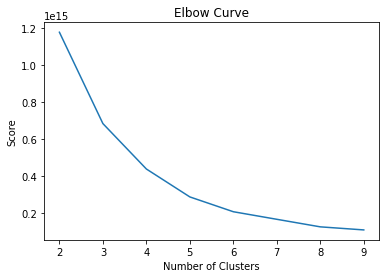

In [0]:
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [1,2,3,4,5,6,7,8]
df_cost.insert(0, 'cluster', new_col)
 
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Based on the elbow curve graph, we observed that a cluster size of 7 or 8 had comparatively less error and cost. Therefore, we ran a model on the same k value to understand the analysis better.

From the above chart we see that Logistic Regression is a better model with more accuracy compared to Linear SVC